In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers

In [18]:
final_df = pd.read_csv("../data/final_features_with_targets.csv", parse_dates=['Date'], index_col='Date')
print(final_df.columns)
asset = 'Gold'

feature_cols = [col for col in final_df.columns if not col.endswith('_target_5d')]
target_cols = [col for col in final_df.columns if col.endswith('_target_5d')]

X_asset = final_df[[col for col in final_df.columns if col.startswith(asset) and not col.endswith('_target_5d')]]
y_asset = final_df[f"{asset}_target_5d"]

X_asset, y_asset = X_asset.dropna(), y_asset.dropna()
X_asset, y_asset = X_asset.align(y_asset, join='inner', axis=0)

Index(['EEM_log_ret', 'Gold_log_ret', 'FTSE100_log_ret', 'S&P500_log_ret',
       'Nikkei225_log_ret', 'UST10Y_log_ret', 'EEM_vol_30d', 'Gold_vol_30d',
       'FTSE100_vol_30d', 'S&P500_vol_30d', 'Nikkei225_vol_30d',
       'UST10Y_vol_30d', 'EEM_zscore', 'Gold_zscore', 'FTSE100_zscore',
       'S&P500_zscore', 'Nikkei225_zscore', 'UST10Y_zscore', 'EEM_sma5',
       'Gold_sma5', 'FTSE100_sma5', 'S&P500_sma5', 'Nikkei225_sma5',
       'UST10Y_sma5', 'EEM_macd', 'Gold_macd', 'FTSE100_macd', 'S&P500_macd',
       'Nikkei225_macd', 'UST10Y_macd', 'EEM_vol_spike', 'Gold_vol_spike',
       'FTSE100_vol_spike', 'S&P500_vol_spike', 'Nikkei225_vol_spike',
       'UST10Y_vol_spike', 'covid_flag', 'EEM_target_5d', 'Gold_target_5d',
       'FTSE100_target_5d', 'S&P500_target_5d', 'Nikkei225_target_5d',
       'UST10Y_target_5d'],
      dtype='object')


In [7]:
split_idx = int(len(X_asset) * 0.8)
X_train, X_val = X_asset[:split_idx], X_asset[split_idx:]
y_train, y_val = y_asset[:split_idx], y_asset[split_idx:]

In [8]:
def build_model(hp):
    model = keras.Sequential()
    
    # Input layer
    model.add(layers.Input(shape=(X_asset.shape[1],)))

    # Tune number of hidden layers: 1 to 3
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(layers.Dense(
            units=hp.Int(f"units_{i}", min_value=32, max_value=256, step=32),
            activation=hp.Choice("activation", ["relu", "tanh"])
        ))
    
    # Output layer
    model.add(layers.Dense(1, activation='linear'))
    
    # Tune optimizer and learning rate
    optimizer = hp.Choice("optimizer", ["adam", "rmsprop", "sgd"])
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )
    
    return model

In [9]:
tuner = kt.RandomSearch(
    build_model,                 # function previously created 
    objective='val_loss',        # Minimize validation loss
    max_trials=10,               #  different combinations
    executions_per_trial=2,      # Train each model twice and average the results
    directory='kt_mlp_tuning_new',   # Folder to save search results
    project_name= f"{asset}_MLP",
    seed = 42 
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, verbose=1)

Trial 10 Complete [00h 02m 05s]
val_loss: 0.00027562187460716814

Best val_loss So Far: 0.000121529315947555
Total elapsed time: 00h 20m 37s


In [10]:
best_hp = tuner.get_best_hyperparameters(1)[0]

model = build_model(best_hp)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
verbose=1
)

Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1901 - mae: 0.2253 - val_loss: 1.6088e-04 - val_mae: 0.0092
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.2178e-04 - mae: 0.0080 - val_loss: 1.2796e-04 - val_mae: 0.0077
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.1738e-04 - mae: 0.0078 - val_loss: 1.3311e-04 - val_mae: 0.0079
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.2265e-04 - mae: 0.0077 - val_loss: 1.3235e-04 - val_mae: 0.0083
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.1491e-04 - mae: 0.0076 - val_loss: 1.3049e-04 - val_mae: 0.0078
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.1595e-04 - mae: 0.0076 - val_loss: 1.6715e-04 - val_mae: 0.0095
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.1281e-04 - mae: 0.0077 - val_loss: 1.2176e-04 - val_mae: 0.0076
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.1353e-04 - mae: 0.0079 - val_loss: 1.2388e-04 - val_mae: 0.0078
Epo

In [11]:
y_pred = model.predict(X_val)
#Evaluation 

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"RMSE: {rmse:.5f}")
print(f"MAE : {mae:.5f}")
print(f"R²  : {r2:.5f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RMSE: 0.00964
MAE : 0.00738
R²  : -0.04348


In [12]:

predictions_df = pd.DataFrame({
    'Date': y_val.index,
    'y_true': y_val.values.flatten(),
    'y_pred': y_pred.flatten()
})

predictions_df.to_csv(f"../results/{asset}_mlp_predictions.csv", index=False)
print(f" Predictions saved to ../results/{asset}_mlp_predictions.csv")


 Predictions saved to ../results/Gold_mlp_predictions.csv


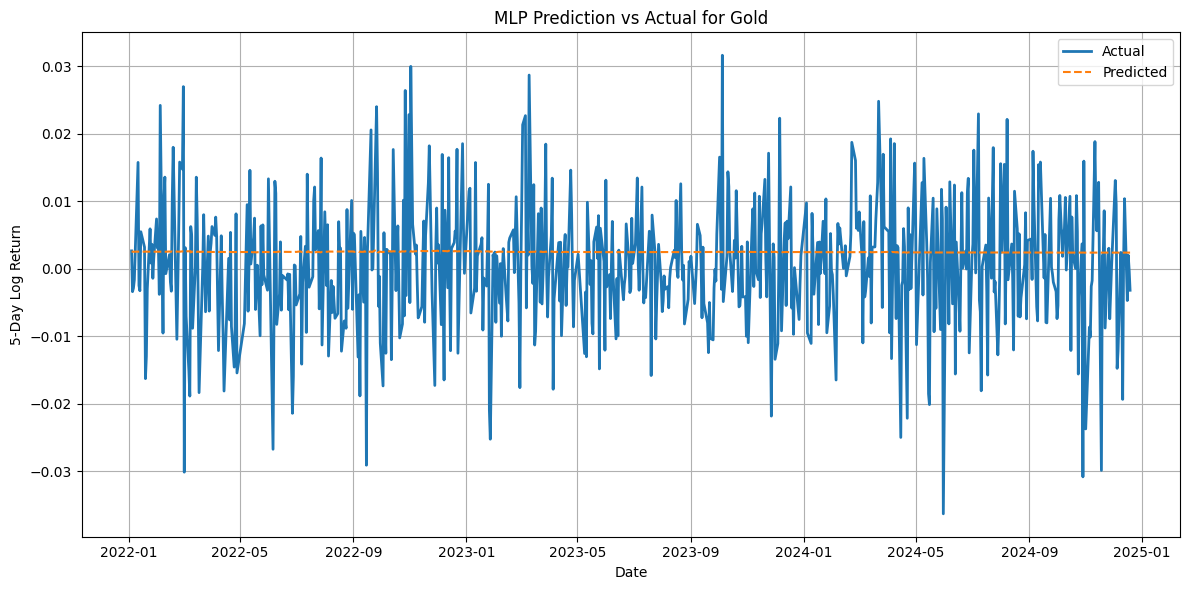

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(predictions_df['Date'], predictions_df['y_true'], label='Actual', linewidth=2)
plt.plot(predictions_df['Date'], predictions_df['y_pred'], label='Predicted', linestyle='--')
plt.title(f'MLP Prediction vs Actual for {asset}')
plt.xlabel('Date')
plt.ylabel('5-Day Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()